In [1]:
#!pip install wordcloud

In [2]:
#!pip install nltk

In [3]:
#!pip install tqdm

In [4]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt 
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS 
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import numpy as np
import scipy as sp
import heapq
from tqdm import tqdm_notebook as tqdm

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.model_selection import GridSearchCV
from random import randint 
from sklearn.decomposition import PCA
from sklearn import metrics

from sklearn import tree
from sklearn.utils import shuffle

In [5]:
import tensorflow as tf

print(tf.__version__)

2.0.0


In [6]:
df = pd.read_csv("Reddit_Election_Posts.csv")

In [7]:
def get_date(created):
    return dt.datetime.fromtimestamp(created)

In [8]:
df['url'].astype(str).str[0:]

0        https://www.reddit.com/r/Liberal/comments/9m2d...
1        https://www.reddit.com/r/Liberal/comments/9m2f...
2        https://www.reddit.com/r/Liberal/comments/9m2i...
3        https://www.reddit.com/r/Liberal/comments/9m2k...
4        https://www.reddit.com/r/Liberal/comments/9m3y...
                               ...                        
27825    http://www.openmarket.org/2012/07/10/quotas-li...
27826    http://www.marketplace.org/topics/wealth-pover...
27827    http://www.denverpost.com/politics-national/20...
27828    http://thoughtcatalog.com/2012/american-discor...
27829    https://www.reddit.com/r/moderatepolitics/comm...
Name: url, Length: 27830, dtype: object

In [9]:
#get posted date, add to df
_timestamp = df["created"].apply(get_date)
df = df.assign(timestamp = _timestamp)

#find election year
df['election year']=df['year'].astype(str).str[0:4]

In [10]:
type(str(df['body'][9]))

str

In [11]:
#feature engineering

url_agency = []
title_len = []
body_del = []
body_removed = []
body_len = []

for x in range(0,len(df)):
    #find url agency, i.e. content source
    if "www." in df['url'][x]:
        y=(df['url'][x].find("."))
        z=df['url'][x].find(".",y+1)
        url_agency.append(df['url'][x][y+1:z])
    
    elif "redd.it" in df['url'][x]:
        url_agency.append('reddit')
    elif "https://" in df['url'][x]:
        z=df['url'][x].find(".",8)
        url_agency.append(df['url'][x][8:z])
    else:
        z=df['url'][x].find(".",7)
        url_agency.append(df['url'][x][7:z])
    
    #find length of post title
    title_len.append(len(df['title'][x]))
    
    if "removed" in str(df['body'][x]):
        body_removed.append(1)
    else:
        body_removed.append(0)
        
    if "deleted" in str(df['body'][x]):
        body_del.append(1)
    else:
        body_del.append(0)

       
    body_len.append(len(str(df['body'][x])))


df['url agency']=url_agency
df['title length']=title_len
df['body removed by moderator']=body_removed
df['body deleted by user']=body_del
df['body length']=body_len

In [12]:
df.head(10)

,subreddit,year,title,score,id,url,comms_num,created,body,timestamp,election year,url agency,title length,body removed by moderator,body deleted by user,body length
0,Liberal,2018-11-06,Changing party affiliation in response to Kave...,13,9m2dtt,https://www.reddit.com/r/Liberal/comments/9m2d...,49,1.538914e+09,"Hey everyone,\n\nSo, I've long tried to be the...",2018-10-07 08:03:17,2018,reddit,51,0,0,1815
1,Liberal,2018-11-06,My mother and I have decided to cut off commun...,1,9m2f5d,https://www.reddit.com/r/Liberal/comments/9m2f...,0,1.538914e+09,[removed],2018-10-07 08:09:44,2018,reddit,65,1,0,9
2,Liberal,2018-11-06,What can I do to help?,0,9m2ixb,https://www.reddit.com/r/Liberal/comments/9m2i...,10,1.538915e+09,[deleted],2018-10-07 08:28:44,2018,reddit,22,0,1,9
3,Liberal,2018-11-06,The current World Population is estimated to b...,4,9m2kyh,https://www.reddit.com/r/Liberal/comments/9m2k...,8,1.538916e+09,[deleted],2018-10-07 08:39:28,2018,reddit,145,0,1,9
4,Liberal,2018-11-06,"С кем поведешься, от того и наберешься",1,9m3ygv,https://www.reddit.com/r/Liberal/comments/9m3y...,0,1.538935e+09,[removed],2018-10-07 13:49:12,2018,reddit,38,1,0,9
5,Liberal,2018-11-06,Was the effort of trying to stop Kavanaugh fro...,5,9m48rx,https://www.reddit.com/r/Liberal/comments/9m48...,27,1.538939e+09,[deleted],2018-10-07 14:57:37,2018,reddit,83,0,1,9
6,Liberal,2018-11-06,Can Kavanaugh be impeached?,4,9m5qno,https://www.reddit.com/r/Liberal/comments/9m5q...,21,1.538954e+09,If there's a proper investigation and it's cle...,2018-10-07 19:11:39,2018,reddit,27,0,0,133
7,Liberal,2018-11-06,This will either prove that liberals are the F...,3,9m5xj2,https://www.reddit.com/r/Liberal/comments/9m5x...,0,1.538955e+09,[removed],2018-10-07 19:36:13,2018,reddit,148,1,0,9
8,Liberal,2018-11-06,New Brunswick's 2018 Election - Explanation - ...,1,9m60wu,https://www.youtube.com/watch?v=JhVTRUyZviw,1,1.538956e+09,NaN,2018-10-07 19:48:04,2018,youtube,62,0,0,3
9,Liberal,2018-11-06,"'Let's Do This': After Owning Liberals Today, ...",0,9m62mn,https://townhall.com/tipsheet/mattvespa/2018/1...,0,1.538956e+09,NaN,2018-10-07 19:54:04,2018,townhall,109,0,0,3


In [13]:
df['subreddit'].value_counts()

Conservative        24175
Liberal              2916
moderatepolitics      739
Name: subreddit, dtype: int64

In [14]:
df['election year'].value_counts()

2018    10308
2012     7319
2016     5603
2014     4600
Name: election year, dtype: int64

## Scores and Number of Comments per Post

**Extreme Outlier Note:**
There is an extreme outlier in the conservative thread titled: "Why we won", which happened after the 2016 election. This must have happened late in the evening so that it still technically happened on the election day. 
<br>
Link [here](https://www.reddit.com/r/Conservative/comments/5c3xah/why_we_won/)

<Figure size 1332x756 with 0 Axes>

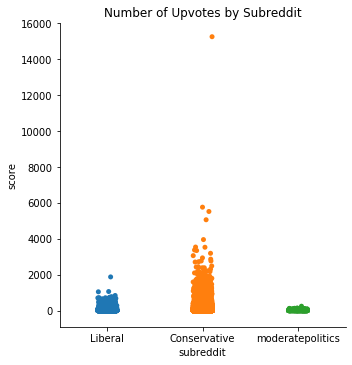

In [15]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
sns.catplot(x="subreddit", y="score", data=df);
plt.title("Number of Upvotes by Subreddit")
plt.show()

<Figure size 1332x756 with 0 Axes>

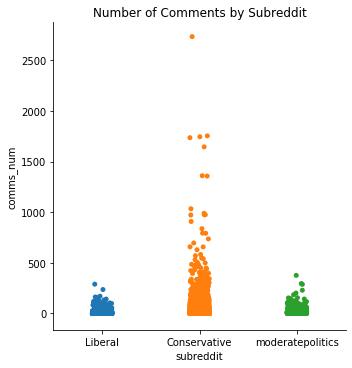

In [16]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
sns.catplot(x="subreddit", y="comms_num", data=df);
plt.title("Number of Comments by Subreddit")
plt.show()

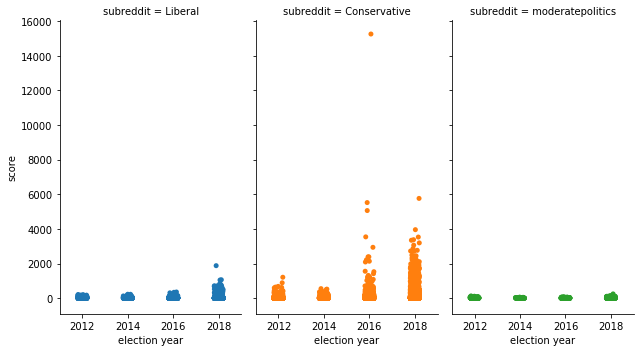

In [17]:
sns.catplot(x="election year", y="score", hue="subreddit",
            col="subreddit", aspect=.6,
             data=df);


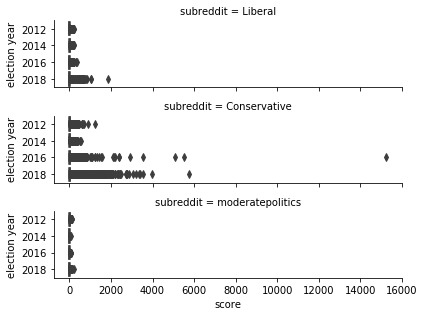

In [18]:
g = sns.catplot(x="score", y="election year", row="subreddit",
                kind="box", orient="h", height=1.5, aspect=4,
                data=df)


## Body Length & Actual Content Per Post

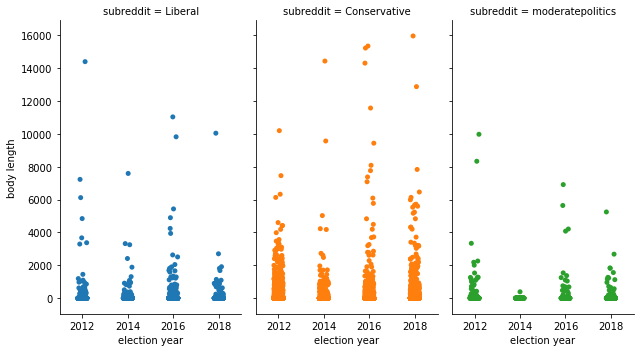

In [19]:
sns.catplot(x="election year", y="body length", hue="subreddit",
            col="subreddit", aspect=.6,
             data=df);



## Overall Trends

#### Posts appear to be up to 300 characters long, which aligns fairly well with twitter specifications

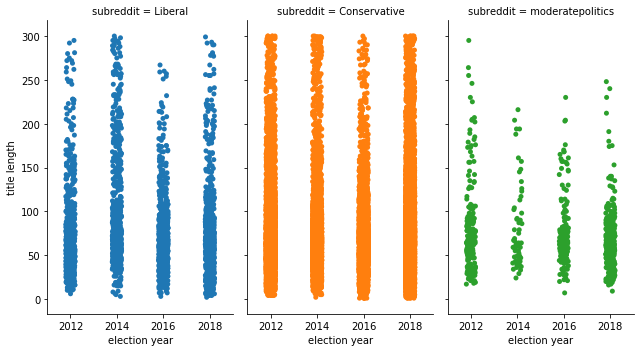

In [20]:
sns.catplot(x="election year", y="title length", hue="subreddit",
            col="subreddit", aspect=.6,
             data=df);



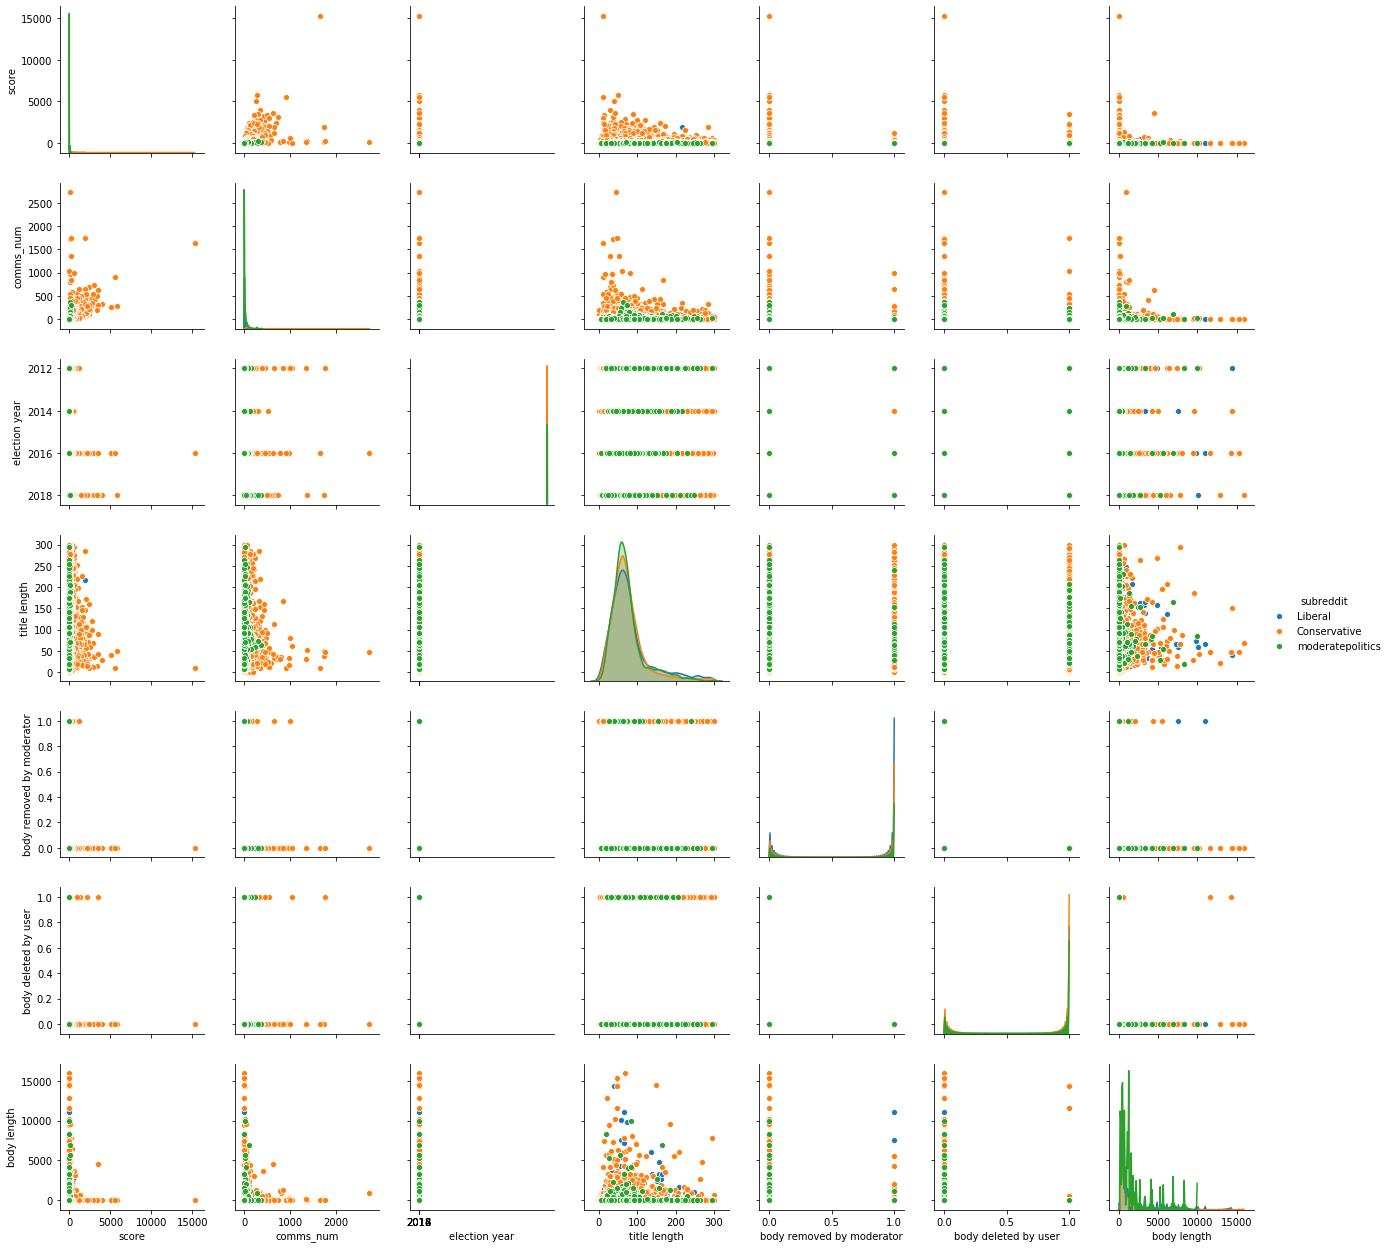

In [21]:
sns.pairplot(data=df.drop(columns=['created']), hue="subreddit");


In [22]:
subreddits = ["Conservative","Liberal","moderatepolitics"]

### News Sources

In [23]:
content_counts = df['url agency'].value_counts()

In [24]:
content_counts[0:30]

reddit                4898
youtube               1394
breitbart              872
i                      602
foxnews                562
youtu                  507
dailycaller            450
nationalreview         441
dailywire              421
thegatewaypundit       393
thehill                383
freebeacon             351
washingtonpost         348
imgur                  330
hotair                 329
nytimes                299
washingtontimes        289
washingtonexaminer     263
townhall               260
politico               247
americanthinker        222
thefederalist          213
twitter                188
realclearpolitics      186
nypost                 186
news                   181
newsbusters            179
m                      157
theblaze               157
pjmedia                155
Name: url agency, dtype: int64

Text(0.5, 0, 'characters')

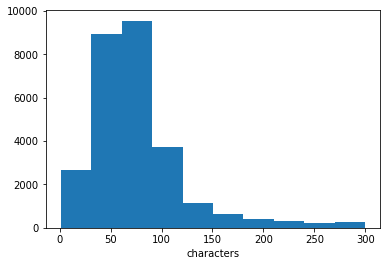

In [25]:
plt.hist(df['title length'])
plt.xlabel('characters')

In [26]:
# def lexical_diversity(text):
#     return len(set(text)) / len(text)
# print('lexical diversity in conservative posts (*100):', lexical_diversity(df_new[df_new['class']=='Conservative'])*100)
# print('lexical diversity in liberal posts (*100):', lexical_diversity(df_new[df_new['class']=='Liberal'])*100)
# print('lexical diversity in moderate posts (*100):', lexical_diversity(df_new[df_new['class']=='moderatepolitics'])*100)
# print('Moderate posts use a more diverse lexicon than the rest')

# NLTK Analysis

In [27]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jschneids13/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [28]:
def stringinize(df):
    comment_words = ' '
    token_list = []
    
    for x in df['title']:

        # typecaste each val to string      
        val = str(x.strip()) 

        # split the value 
        #tokens = val.split() 
        
        #tokenize
        tokens = word_tokenize(x)
        
        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        for words in tokens: 
            comment_words = comment_words + words + " "
            token_list.append(words)
    
    return comment_words, token_list

In [29]:
# make NLTK dataset for dictionaries with words for each subreddit

word_dict = { "subreddit":[], 
                "comment_words":[], 
                "token_list":[]}

for x in subreddits:
    df_temp = df.loc[df['subreddit']==x]
    print(x)
    
    
    word_dict["subreddit"].append(str(x))
    
    comment_words, token_list = stringinize(df_temp)
    word_dict["comment_words"].append(comment_words)
    word_dict["token_list"].append(token_list)

Conservative
Liberal
moderatepolitics


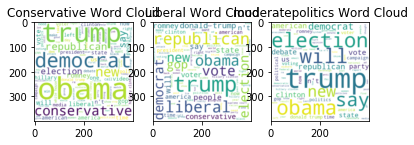

In [30]:
stopwords = set(STOPWORDS)

fig, (ax1, ax2, ax3) = plt.subplots(1,3)

for x, y,z in zip(word_dict['comment_words'], subreddits,[ax1, ax2, ax3]):    
    wordcloud = WordCloud(width = 400, height = 400, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10,
                     collocations = True).generate(x) 
  
    # plot the WordCloud image
    #plt.figure(figsize = (5,5), facecolor = None) 
    z.set_title(str(y) + " Word Cloud")
    z.imshow(wordcloud, interpolation="bilinear")

In [ ]:
for x in ['-','|','--', '$', '%', '.', ',','?',':',';',"'", '"', "'s", 's', '&', '[',']',"'m",
            '...', '(',')','!', '``','‘',"n't","’", "'"," ``","''", "”", '“','t', "'ve'"]:
    stopwords.add(x)

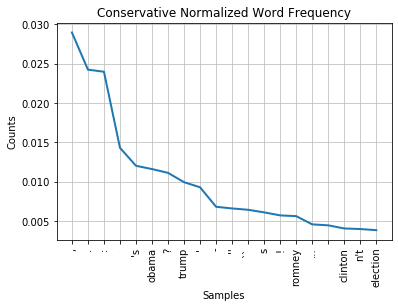

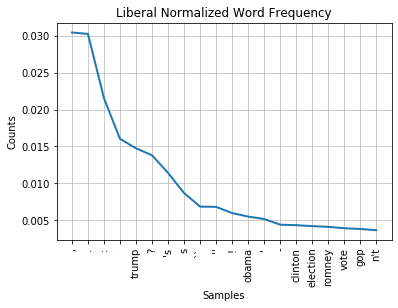

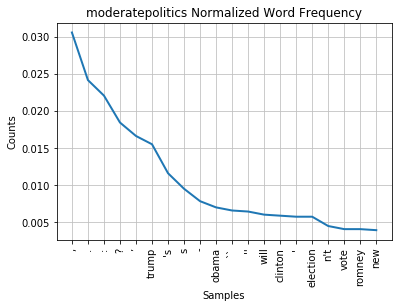

In [31]:
class_list = []
freq_list = []
word_list = []
z=0

for x, y in zip(word_dict['token_list'], subreddits):    
    filtered_sentence = [] 

    for w in x: 
        if w not in stopwords: 
            filtered_sentence.append(w) 


    fd = nltk.FreqDist(filtered_sentence)
    total = fd.N()
    for word in fd:
        fd[word] /= float(total)
    
    fd.plot(20,cumulative=False,title = str(y)+" Normalized Word Frequency")
    
    for word in fd:
        word_list.append(word)
        freq_list.append(fd[word])
        class_list.append(y)

In [32]:
freq_df = pd.DataFrame({'class':class_list,
                        "word":word_list,
                 "frequency":freq_list})

freq_df.sort_values(['frequency'], ascending = False).head(40) 

freq_df_top_conservative = freq_df.loc[freq_df['class']=='Conservative'].sort_values(by=['frequency'],ascending=False).head(30)
word_list = list(freq_df_top_conservative['word'])

top_freq_df = freq_df.loc[freq_df['word'].isin(word_list)]
top_freq_df=top_freq_df.sort_values(by=['frequency'],ascending=False)


## Plot of top 30 conservative words by ideological group

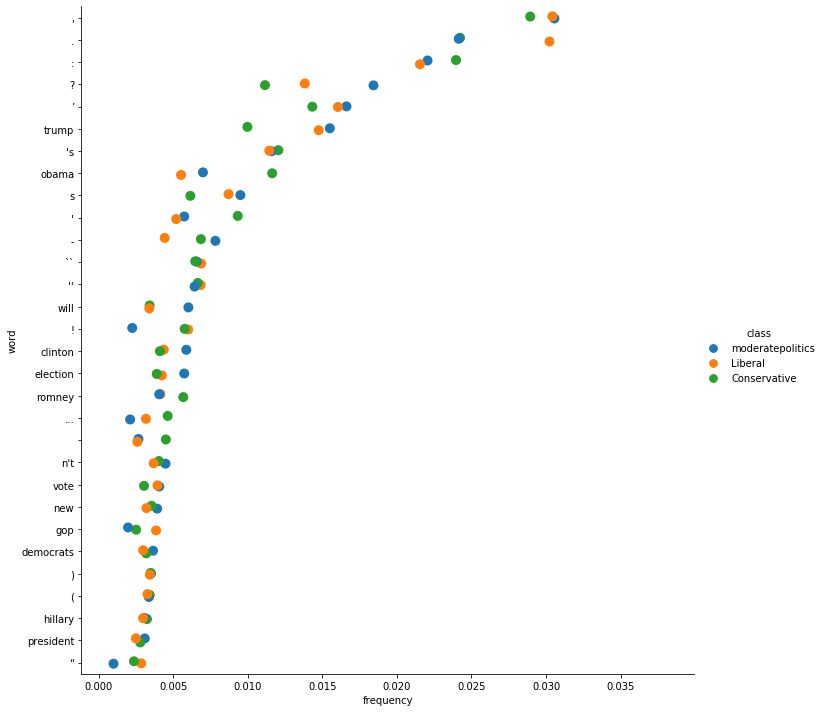

In [33]:
g=sns.catplot(y="word", x="frequency",hue="class", 
             edgecolor=".6",s=10,aspect=15/15,height=10, 
            data=top_freq_df)



In [34]:
freq_df.to_csv("Reddit Word Frequencies.csv",index=False)

In [332]:
df = pd.read_csv("reddit_test_posts.csv")

In [333]:
#filter for 2018 posts only
df_18 = df.loc[df['election year']==2018]

In [334]:
df_18['subreddit'].value_counts()

politics             42954
Economics             1295
arizonapolitics        148
wisconsinpolitics       74
Name: subreddit, dtype: int64

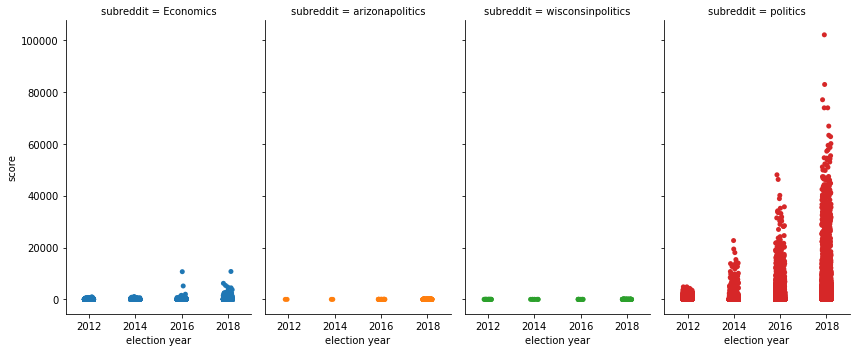

In [335]:
sns.catplot(x="election year", y="score", hue="subreddit",
            col="subreddit", aspect=.6,
             data=df);



In [336]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jschneids13/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [337]:
def stringinize(df):
    comment_words = ' '
    token_list = []
    
    for x in df['title']:

        # typecaste each val to string      
        val = str(x.strip()) 

        # split the value 
        #tokens = val.split() 
        
        #tokenize
        tokens = word_tokenize(x)
        
        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        for words in tokens: 
            comment_words = comment_words + words + " "
            token_list.append(words)
    
    return comment_words, token_list

In [380]:
subreddits = ['Economics','wisconsinpolitics',
             'arizonapolitics','politics']

In [381]:
# make NLTK dataset for dictionaries with words for each subreddit

word_dict = { "subreddit":[], 
                "comment_words":[], 
                "token_list":[]}

for x in subreddits:
    df_temp = df_18.loc[df_18['subreddit']==x]
    
    
    word_dict["subreddit"].append(str(x))
    
    comment_words, token_list = stringinize(df_temp)
    word_dict["comment_words"].append(comment_words)
    word_dict["token_list"].append(token_list)

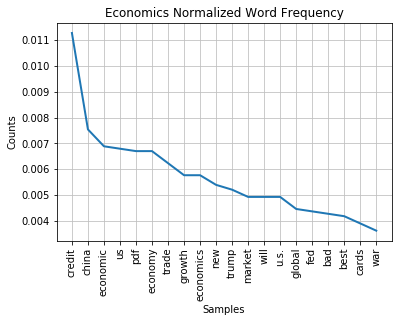

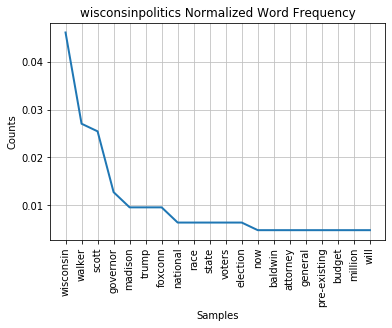

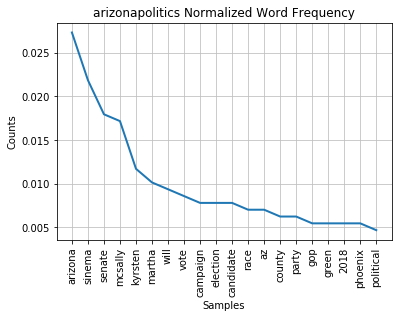

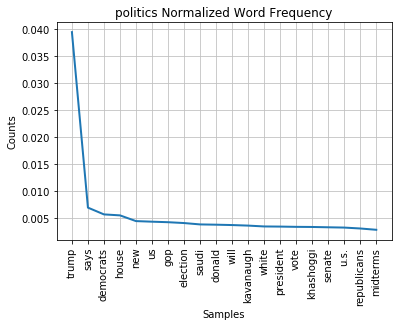

In [382]:
class_list = []
freq_list = []
word_list = []
z=0

for x, y in zip(word_dict['token_list'], subreddits):    
    filtered_sentence = [] 

    for w in x: 
        if w not in stopwords: 
            filtered_sentence.append(w) 


    fd = nltk.FreqDist(filtered_sentence)
    total = fd.N()
    for word in fd:
        fd[word] /= float(total)
    
    fd.plot(20,cumulative=False,title = str(y)+" Normalized Word Frequency")
    
    for word in fd:
        word_list.append(word)
        freq_list.append(fd[word])
        class_list.append(y)

In [383]:
df_new = pd.DataFrame(df_18['title'])

In [384]:
def get_tokens(df):
    tokens_clean = []
    for post in tqdm(range(len(df))):
        x = df['title'][post]
        # typecaste each val to string and strip     
        val = str(x.strip())       
        #tokenize
        tokens = word_tokenize(val)
        for word in tokens:
            word = word.lower()
            if word not in stopwords:
                tokens_clean.append(word)
        
    fd = nltk.FreqDist(tokens_clean)
    return fd



In [385]:
wordfreq = get_tokens(df_new)
most_freq = heapq.nlargest(200, wordfreq, key=wordfreq.get)

/opt/anaconda3/envs/tfcs109a/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [386]:
import heapq
most_freq = heapq.nlargest(50000, wordfreq, key=wordfreq.get)

In [387]:
def get_matrix(df,most_freq):    #some code from https://stackabuse.com/python-for-nlp-creating-bag-of-words-model-from-scratch/
    post_vectors = []
    for post in tqdm(range(len(df))):
        x = df['title'][post]
        val = str(x.strip())  
        post_tokens = nltk.word_tokenize(val)
        post_vec = []
        for token in most_freq:
            if token in post_tokens:
                post_vec.append(1)
            else:
                post_vec.append(0)
        post_vectors.append(post_vec)
        
    return post_vectors

In [388]:
post_matrix = get_matrix(df_new,most_freq)

/opt/anaconda3/envs/tfcs109a/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [389]:
post_matrix = np.asarray(post_matrix)
df_post = pd.DataFrame(post_matrix, columns = most_freq)
df_post['subreddit_class']=df_18['subreddit']
#df_post.to_csv("post_matrix.csv", index=False)



In [390]:
preds = pd.read_csv("X_test_smaller.csv")

In [391]:
col_names = preds.columns

In [392]:
n=0
col_nums = []
bad_col_names = []
for x in col_names:
    if x in df_post.columns:
        n+=1
        y = str(x)
        col_nums.append(df_post.columns.get_loc(x))
    else:
        bad_col_names.append(x)

df_final = df_post.iloc[:,col_nums]
df_final['subreddit_class'] = df_post['subreddit_class']

/opt/anaconda3/envs/tfcs109a/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [393]:
for x in bad_col_names:
    df_final[x]=0

/opt/anaconda3/envs/tfcs109a/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [394]:
politics = df_final.loc[df_final['subreddit_class']=='politics']
Economics = df_final.loc[df_final['subreddit_class']=='Economics']
arizonapolitics = df_final.loc[df_final['subreddit_class']=='arizonapolitics']
wisconsinpolitics = df_final.loc[df_final['subreddit_class']=='wisconsinpolitics']

politics_one = politics[:20000]
politics_two = politics[20000:]


In [395]:
politics_one.to_csv("politics_one.csv")
politics_two.to_csv("politics_two.csv")
Economics.to_csv("Economics.csv")
arizonapolitics.to_csv("arizonapolitics.csv")
wisconsinpolitics.to_csv("wisconsinpolitics.csv")


# Function to generate frame of posts as rows and words as columns

In [35]:
df_new = pd.DataFrame(df['title'])
df_new['class'] = df['subreddit']

In [36]:
df_short = df_new.head(100)
#df_short.head(10)

In [37]:
stopwords = set(STOPWORDS)

for x in ['-','|','--', '$', '%', '.', ',','?',':',';',"'", '"', "'s", 's', '&', '[',']',"'m",
            '...', '(',')','!', '``','‘',"n't","’", "'"," ``","''", "”", '“','t', "'ve'"]:
    stopwords.add(x)

In [38]:
def get_tokens(df):
    tokens_clean = []
    for post in tqdm(range(len(df))):
        x = df['title'][post]
        # typecaste each val to string and strip     
        val = str(x.strip())       
        #tokenize
        tokens = word_tokenize(val)
        for word in tokens:
            word = word.lower()
            if word not in stopwords:
                tokens_clean.append(word)
        
    fd = nltk.FreqDist(tokens_clean)
    return fd
        

In [39]:
wordfreq = get_tokens(df_new)
most_freq = heapq.nlargest(200, wordfreq, key=wordfreq.get)

/opt/anaconda3/envs/tfcs109a/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
import heapq
most_freq = heapq.nlargest(10000, wordfreq, key=wordfreq.get)

In [41]:
def get_matrix(df,most_freq):    #some code from https://stackabuse.com/python-for-nlp-creating-bag-of-words-model-from-scratch/
    post_vectors = []
    for post in tqdm(range(len(df))):
        x = df['title'][post]
        val = str(x.strip())  
        post_tokens = nltk.word_tokenize(val)
        post_vec = []
        for token in most_freq:
            if token in post_tokens:
                post_vec.append(1)
            else:
                post_vec.append(0)
        post_vectors.append(post_vec)
        
    return post_vectors

In [42]:
post_matrix = get_matrix(df_new,most_freq)

/opt/anaconda3/envs/tfcs109a/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


## Get the potentially best predictors

Now we calculate t-tests and chi-squared tests to find the words whose frequency vary the most across subreddits.

In [43]:
post_matrix = np.asarray(post_matrix)
df_post = pd.DataFrame(post_matrix, columns = most_freq)
df_post['reddit_class'] = df_new['class']

In [44]:
np.random.seed(10)

X_train, X_test, y_train, y_test = train_test_split(df_post, 
                                                         df_post['reddit_class'], test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = df_post['reddit_class'])

In [45]:
con = X_train[X_train['reddit_class']=='Conservative']
lib = X_train[X_train['reddit_class']=='Liberal']
mod = X_train[X_train['reddit_class']=='moderatepolitics']

In [46]:
# now we can take out the y, since we have already dividided the groups for the tests
lib = lib.loc[:, lib.columns != 'reddit_class']
mod = mod.loc[:, mod.columns != 'reddit_class']
con = con.loc[:, con.columns != 'reddit_class']

X_train = X_train.loc[:, X_train.columns != 'reddit_class']
X_test = X_test.loc[:, X_test.columns != 'reddit_class']

In [47]:
# t-test between conservative and liberal
words_t = []
t1 = []

for i in tqdm(range(len(con.columns))):
    t1.append(np.absolute(sp.stats.ttest_ind(con.iloc[:,i], lib.iloc[:,i], equal_var=False)[0]))
    
    


/opt/anaconda3/envs/tfcs109a/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [48]:
ordered_predictors = pd.DataFrame(most_freq, columns=['word'])
ordered_predictors['t-test'] = t1
ordered_predictors = ordered_predictors.sort_values('t-test', ascending=False)

In [49]:
ordered_predictors.to_csv("Ordered Predictors.csv",index=False)

In [50]:
print('differenciation ranking of word Obama:',ordered_predictors['word'].tolist().index('obama'))
print('differenciation ranking of word Trump:', ordered_predictors['word'].tolist().index('trump'))
print('In contrast to a big part of the literature, candidate names do not appear to be good predictors here')

differenciation ranking of word Obama: 6873
differenciation ranking of word Trump: 6667
In contrast to a big part of the literature, candidate names do not appear to be good predictors here


In [51]:
#let's use only those with t-test value higher than 2
top_predictors = ordered_predictors.head(1308)
top_predictors.to_csv("Top Predictors.csv",index=False)

# New dataframes for training and testing the models

In [52]:
X_train_smaller = X_train[top_predictors['word']]
X_test_smaller = X_test[top_predictors['word']]

In [53]:
y_train.to_csv("y_train.csv",index=False)
y_test.to_csv("y_test.csv",index=False)

/opt/anaconda3/envs/tfcs109a/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.
/opt/anaconda3/envs/tfcs109a/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [54]:
# small X_train
X_train_smaller.to_csv("X_train_smaller.csv",index=False)
X_test_smaller.to_csv("X_test_smaller.csv",index=False)

In [55]:
# Medium X_train
ordered_predictors = pd.read_csv("Ordered Predictors.csv")

#let's chose the top 3000
top_predictors_med = ordered_predictors.head(3000)

#build new matrix
X_train_medium = X_train[top_predictors_med['word']]
X_test_medium = X_test[top_predictors_med['word']]

In [56]:
# Large X_train
ordered_predictors = pd.read_csv("Ordered Predictors.csv")

#let's chose the top 3000
top_predictors_large = ordered_predictors.head(9000)

#build new matrix
X_train_large = X_train[top_predictors_large['word']]
X_test_large = X_test[top_predictors_large['word']]

# Predicting political orientation of the posts


In [57]:
X_train_smaller = pd.read_csv("X_train_smaller.csv")
X_test_smaller = pd.read_csv("X_test_smaller.csv")
y_train_short = pd.read_csv("y_train.csv")
y_test_short = pd.read_csv("y_test.csv")

# reshape y_train
new_row = pd.DataFrame({'Liberal':'Liberal'}, index =[0])  
y_train = pd.concat([new_row, y_train_short]).reset_index(drop = True).rename(columns={"Liberal": "class"}) 
# reshape y_test
new_row = pd.DataFrame({'moderatepolitics':'moderatepolitics'}, index =[0])  
y_test = pd.concat([new_row, y_test_short]).reset_index(drop = True).rename(columns={"moderatepolitics": "class"}) 

In [58]:
print(y_train.shape)

(22264, 1)


In [59]:
print(y_train["class"])

0             Liberal
1        Conservative
2        Conservative
3        Conservative
4        Conservative
             ...     
22259    Conservative
22260    Conservative
22261    Conservative
22262    Conservative
22263    Conservative
Name: class, Length: 22264, dtype: object


In [60]:
from sklearn.metrics import confusion_matrix

In [61]:
import itertools

In [62]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=24)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, fontsize=16)
        plt.yticks(tick_marks, target_names,fontsize=16)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label',fontsize=18)
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass),fontsize=18)
    plt.show()

#### Linear models

In [63]:
# multi regression model   Code from HW5 solutions
multi_regr = LogisticRegression(C=100000, solver = "lbfgs", max_iter=100000, multi_class="ovr", random_state=81, verbose=1)
multi_regr.fit(X_train_smaller, y_train["class"])
print("Done: Step 1")

# predictions
y_train_pred_multi = multi_regr.predict(X_train_smaller) 
y_test_pred_multi = multi_regr.predict(X_test_smaller)
print("Done: Step 2")


# accuracy
train_score_multi = accuracy_score(y_train, y_train_pred_multi)
test_score_multi = accuracy_score(y_test, y_test_pred_multi)

print('Training set accuracy for multiple logistic regression = ', train_score_multi)
print('Test set accuracy for multiple logistic regression = ', test_score_multi)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Done: Step 1
Done: Step 2
Training set accuracy for multiple logistic regression =  0.8730237154150198
Test set accuracy for multiple logistic regression =  0.8614804168163852


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   45.0s finished


In [64]:
y_test_pred_multi = pd.DataFrame(y_test_pred_multi)
y_test_pred_multi[0].value_counts()

Conservative        5508
Liberal               36
moderatepolitics      22
Name: 0, dtype: int64

In [65]:
y_test["class"].value_counts()

Conservative        4835
Liberal              583
moderatepolitics     148
Name: class, dtype: int64

In [66]:
confusion_matrix_logistic = confusion_matrix(y_test["class"], y_test_pred_multi[0])
print(confusion_matrix_logistic)

[[4787   27   21]
 [ 574    8    1]
 [ 147    1    0]]


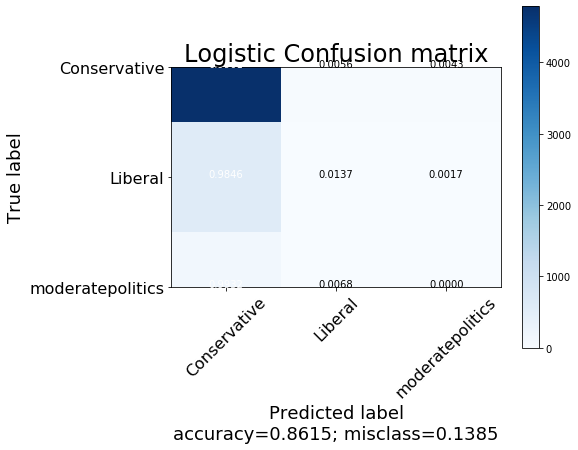

In [67]:
plot_confusion_matrix(cm = confusion_matrix_logistic,
                      target_names = ['Conservative', 'Liberal', 'moderatepolitics'],
                      title='Logistic Confusion matrix',
                      cmap=None,
                      normalize=True)

In [68]:
# fitting regularized multi regression model - L1 penalty     - Code from HW5 solutions

logit_regr_lasso = LogisticRegressionCV(solver='liblinear', penalty='l1', cv=5, verbose = 1)
logit_regr_lasso.fit(X_train_smaller, y_train["class"])

# predictions
y_train_pred_lasso = logit_regr_lasso.predict(X_train_smaller) 
y_test_pred_lasso = logit_regr_lasso.predict(X_test_smaller)

# accuracy
train_score_lasso = accuracy_score(y_train, y_train_pred_lasso)
test_score_lasso = accuracy_score(y_test, y_test_pred_lasso)

print('Training set accuracy for multiple logistic regression = ', train_score_lasso)
print('Test set accuracy for multiple logistic regression = ', test_score_lasso)

/opt/anaconda3/envs/tfcs109a/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    5.8s finished


Training set accuracy for multiple logistic regression =  0.8718109953287819
Test set accuracy for multiple logistic regression =  0.8652533237513474


#### PCA

This could help with the high dimensionality problem we have.

In [69]:
pca = PCA().fit(X_train_smaller)
pca_xtrain = pca.transform(X_train_smaller)
pca_xtest = pca.transform(X_test_smaller)

print(pca.components_.shape)
print("pca shape in train:", pca_xtrain.shape, "and pca shape in test:", pca_xtest.shape)

(1308, 1308)
pca shape in train: (22264, 1308) and pca shape in test: (5566, 1308)


In [70]:
pca_df = pd.DataFrame(pca_xtrain[:,0:17], columns=['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9',
                                                  'PCA10', 'PCA11', 'PCA12', 'PCA13', 'PCA14', 'PCA15', 'PCA16', 'PCA17'])
pca_df['class'] = y_train.values

Variance explained: 0.18507619116741764
number of components that explain at least 90% of the variance= 1309


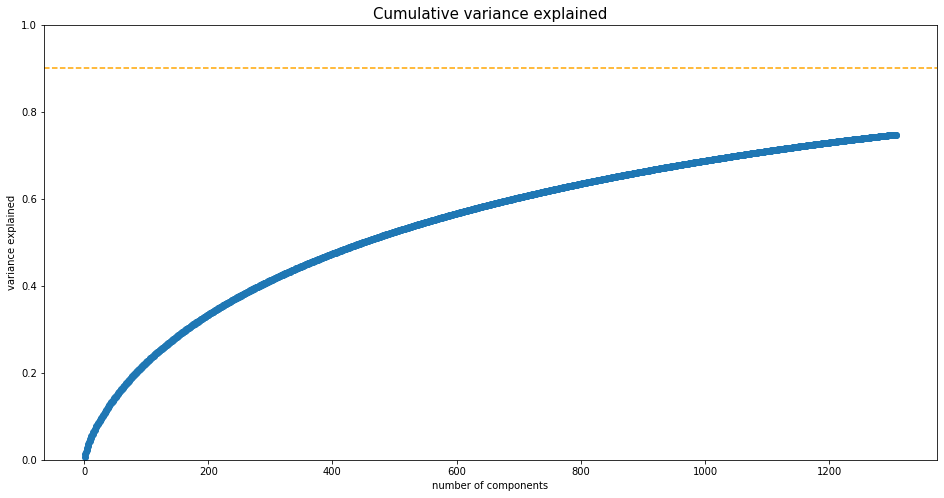

In [71]:
# Let's see how much variance they explain

print( "Variance explained:", np.sum(pca.explained_variance_ratio_[0:17]))

# finding top 17 components
var_explained = []
total_comp = 1308
pca = PCA(n_components = total_comp).fit(X_train)

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(range(1, total_comp+1), np.cumsum(pca.explained_variance_ratio_), 'o-')
ax.axhline(0.9, linestyle='--', color='orange')
ax.set_ylim(0,1)
ax.set_xlabel('number of components')
ax.set_ylabel('variance explained')
ax.set_title('Cumulative variance explained',fontsize=15)

print("number of components that explain at least 90% of the variance=",\
    len(np.where(np.cumsum(pca.explained_variance_ratio_)<=0.9)[0])+1)

In [72]:
# PCR

cv_scores = []
pcs = [2, 17, 1300]

for pc in pcs:
    pca = PCA(n_components = pc).fit(X_train_smaller)
    
    X_train_pca = pca.transform(X_train_smaller)
    X_test_pca = pca.transform(X_test_smaller)
    
    logreg_pca = LogisticRegression(C=100000, fit_intercept=False, solver='lbfgs', max_iter=10000, verbose = 1)
    logreg_pca.fit(X_train_pca, y_train["class"])
    
    cv_scores.append(np.mean(cross_val_score(logreg_pca, X_train_pca, y_train["class"], cv=5)))
    
pd.DataFrame(cv_scores, columns=['CV Score'])

/opt/anaconda3/envs/tfcs109a/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
/opt/anaconda3/envs/tfcs109a/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
/opt/anaconda3/envs/tfcs109a/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class

,CV Score
0,0.528805
1,0.805381
2,0.835471


#### Random Forest

First iterations were predicting Conservative to almost everything. We noticed that using a small subset of predictors did not help.

In [73]:
import math
preds = round(math.sqrt(X_train_smaller.shape[1]))

In [74]:
# Initial Random Forest
model = RandomForestClassifier(n_estimators=55, max_depth=20, max_features=preds) # code from section 7
model.fit(X_train_smaller, y_train["class"])

#Predict
y_pred_train = model.predict(X_train_smaller)
y_pred_test = model.predict(X_test_smaller)

#Perfromance Evaluation
random_forest_train_score = accuracy_score(y_train, y_pred_train)*100
random_forest_test_score = accuracy_score(y_test, y_pred_test)*100

print("Random Forest: Accuracy, Training Set : {:0.2f}%".format(random_forest_train_score))
print("Random Forest: Accuracy, Testing Set :  {:0.2f}%".format(random_forest_test_score))

Random Forest: Accuracy, Training Set : 86.90%
Random Forest: Accuracy, Testing Set :  86.88%


In [75]:
#Find optimal depth of trees   # code taken from section 7
mean_CV_acc = {}
all_CV_acc = {}
tree_depth_start, tree_depth_end, steps = 32, 60, 5
for i in tqdm(range(tree_depth_start, tree_depth_end, steps)):
    model = RandomForestClassifier(n_estimators=55, max_depth=i, max_features=preds)
    score = cross_val_score(estimator=model, X=X_train_smaller, y=y_train["class"], cv=5)
    all_CV_acc[i] = score
    mean_CV_acc[i] = score.mean()
    
best_depth = max(mean_CV_acc, key=mean_CV_acc.get)

/opt/anaconda3/envs/tfcs109a/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [76]:
mean_CV_acc

{32: 0.8686219970355727,
 37: 0.8683524855172567,
 42: 0.8682627592957065,
 47: 0.8681728616031252,
 52: 0.8678136541375088,
 57: 0.8678584668130961}

In [77]:
# Best Random Forest Tree
model_rf = RandomForestClassifier(n_estimators=55, max_depth=1000, max_features=1300, verbose=True) # code from section 7
model_rf.fit(X_train_smaller, y_train["class"])

#Predict
y_pred_train = model_rf.predict(X_train_smaller)
y_pred_test = model_rf.predict(X_test_smaller)

#Perfromance Evaluation
random_forest_train_score = accuracy_score(y_train, y_pred_train)*100
random_forest_test_score = accuracy_score(y_test, y_pred_test)*100

print("Random Forest: Accuracy, Training Set : {:0.2f}%".format(random_forest_train_score))
print("Random Forest: Accuracy, Testing Set :  {:0.2f}%".format(random_forest_test_score))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed: 15.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Random Forest: Accuracy, Training Set : 87.88%
Random Forest: Accuracy, Testing Set :  86.17%


[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.9s finished


In [78]:
a = pd.DataFrame(y_test)
a["class"].value_counts()

Conservative        4835
Liberal              583
moderatepolitics     148
Name: class, dtype: int64

In [79]:
b = pd.DataFrame(y_pred_test)
b[0].value_counts()

Conservative        5493
Liberal               54
moderatepolitics      19
Name: 0, dtype: int64

In [80]:
confusion_matrix_rf = confusion_matrix(y_test["class"], y_pred_test)
print(confusion_matrix_rf)

[[4780   39   16]
 [ 570   13    0]
 [ 143    2    3]]


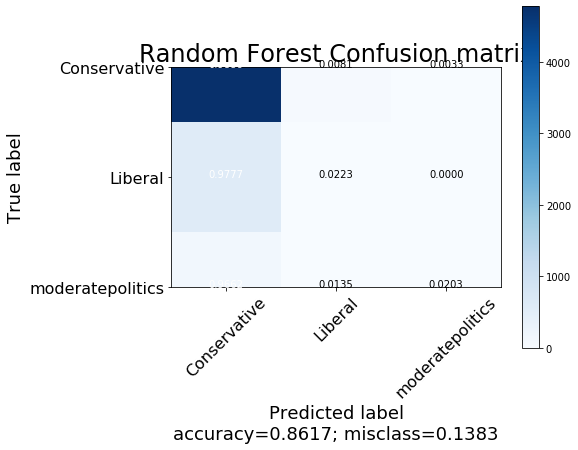

In [81]:
plot_confusion_matrix(cm = confusion_matrix_rf,
                      target_names = ['Conservative', 'Liberal', 'moderatepolitics'],
                      title='Random Forest Confusion matrix',
                      cmap=None,
                      normalize=True)

#### Neural networks

In [82]:
# Transform to Numpy Array

y_train.loc[y_train["class"] == "Conservative"] = 0
y_train.loc[y_train["class"] == "Liberal"] = 1
y_train.loc[y_train["class"] == "moderatepolitics"] = 2

y_train_array = np.array(y_train)
X_train_smaller_array = np.array(X_train_smaller)

X_test_smaller_array = np.array(X_test_smaller)

print(X_train_smaller)
print(y_train_array)

       dead  student  girl  probe  48  ll  thinks  asks  45  allegations  ...  \
0         0        0     0      0   0   0       0     0   0            0  ...   
1         0        0     0      0   0   0       0     0   0            0  ...   
2         0        0     0      0   0   0       1     0   0            0  ...   
3         0        0     0      0   0   0       0     0   0            0  ...   
4         0        0     0      0   0   0       0     0   0            0  ...   
...     ...      ...   ...    ...  ..  ..     ...   ...  ..          ...  ...   
22259     0        0     0      0   0   0       0     0   0            0  ...   
22260     0        0     0      0   0   0       0     0   0            0  ...   
22261     0        0     0      0   0   0       0     0   0            0  ...   
22262     0        0     0      0   0   0       0     0   0            0  ...   
22263     0        0     0      0   0   0       0     0   0            0  ...   

       expert  prepare  des

In [83]:
# Transform to Numpy Array

y_test.loc[y_test["class"] == "Conservative"] = 0
y_test.loc[y_test["class"] == "Liberal"] = 1
y_test.loc[y_test["class"] == "moderatepolitics"] = 2

y_test_array = np.array(y_test)

print(y_test_array)

[[2]
 [1]
 [0]
 ...
 [0]
 [0]
 [1]]


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               130900    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 151,201
Trainable params: 151,201
Non-trainable params: 0
__________________________________________________

15584/15584 [==============================] - 1s 48us/sample - loss: 0.3666 - acc: 0.8692 - val_loss: 0.4681 - val_acc: 0.8632
Epoch 51/500
15584/15584 [==============================] - 1s 48us/sample - loss: 0.3679 - acc: 0.8697 - val_loss: 0.4622 - val_acc: 0.8629
Epoch 52/500
15584/15584 [==============================] - 1s 48us/sample - loss: 0.3678 - acc: 0.8683 - val_loss: 0.4631 - val_acc: 0.8620
Epoch 53/500
15584/15584 [==============================] - 1s 48us/sample - loss: 0.3669 - acc: 0.8695 - val_loss: 0.4635 - val_acc: 0.8626
Epoch 54/500
15584/15584 [==============================] - 1s 48us/sample - loss: 0.3659 - acc: 0.8702 - val_loss: 0.4643 - val_acc: 0.8567
Epoch 55/500
15584/15584 [==============================] - 1s 48us/sample - loss: 0.3657 - acc: 0.8688 - val_loss: 0.4665 - val_acc: 0.8602
Epoch 56/500
15584/15584 [==============================] - 1s 48us/sample - loss: 0.3656 - acc: 0.8695 - val_loss: 0.4652 - val_acc: 0.8626
Epoch 57/500
15584/15584 [

15584/15584 [==============================] - 1s 49us/sample - loss: -928.9363 - acc: 0.8695 - val_loss: 861.9606 - val_acc: 0.8614
Epoch 108/500
15584/15584 [==============================] - 1s 49us/sample - loss: -1025.5027 - acc: 0.8693 - val_loss: 940.3276 - val_acc: 0.8617
Epoch 109/500
15584/15584 [==============================] - 1s 49us/sample - loss: -1119.1038 - acc: 0.8688 - val_loss: 999.3704 - val_acc: 0.8611
Epoch 110/500
15584/15584 [==============================] - 1s 49us/sample - loss: -1144.3567 - acc: 0.8688 - val_loss: 1055.3212 - val_acc: 0.8617
Epoch 111/500
15584/15584 [==============================] - 1s 48us/sample - loss: -1260.5541 - acc: 0.8688 - val_loss: 1147.0413 - val_acc: 0.8612
Epoch 112/500
15584/15584 [==============================] - 1s 48us/sample - loss: -1315.6382 - acc: 0.8695 - val_loss: 1234.2774 - val_acc: 0.8615
Epoch 113/500
15584/15584 [==============================] - 1s 48us/sample - loss: -1495.2699 - acc: 0.8694 - val_loss: 133

Epoch 162/500
15584/15584 [==============================] - 1s 48us/sample - loss: -14692.8704 - acc: 0.8688 - val_loss: 12785.4638 - val_acc: 0.8621
Epoch 163/500
15584/15584 [==============================] - 1s 48us/sample - loss: -15401.2836 - acc: 0.8684 - val_loss: 13082.7973 - val_acc: 0.8620
Epoch 164/500
15584/15584 [==============================] - 1s 48us/sample - loss: -16415.8597 - acc: 0.8684 - val_loss: 13614.0047 - val_acc: 0.8618
Epoch 165/500
15584/15584 [==============================] - 1s 48us/sample - loss: -16326.5275 - acc: 0.8692 - val_loss: 14136.7345 - val_acc: 0.8620
Epoch 166/500
15584/15584 [==============================] - 1s 48us/sample - loss: -17226.5545 - acc: 0.8686 - val_loss: 14596.4464 - val_acc: 0.8620
Epoch 167/500
15584/15584 [==============================] - 1s 48us/sample - loss: -18009.9020 - acc: 0.8685 - val_loss: 14880.7737 - val_acc: 0.8618
Epoch 168/500
15584/15584 [==============================] - 1s 48us/sample - loss: -18163.995

15584/15584 [==============================] - 1s 48us/sample - loss: -62965.1626 - acc: 0.8686 - val_loss: 53728.2367 - val_acc: 0.8620
Epoch 217/500
15584/15584 [==============================] - 1s 49us/sample - loss: -67644.6691 - acc: 0.8692 - val_loss: 55384.8477 - val_acc: 0.8620
Epoch 218/500
15584/15584 [==============================] - 1s 48us/sample - loss: -67730.1726 - acc: 0.8689 - val_loss: 56685.0388 - val_acc: 0.8620
Epoch 219/500
15584/15584 [==============================] - 1s 48us/sample - loss: -69371.1947 - acc: 0.8685 - val_loss: 57452.3172 - val_acc: 0.8620
Epoch 220/500
15584/15584 [==============================] - 1s 48us/sample - loss: -71587.3333 - acc: 0.8685 - val_loss: 58297.4977 - val_acc: 0.8620
Epoch 221/500
15584/15584 [==============================] - 1s 48us/sample - loss: -73292.0502 - acc: 0.8686 - val_loss: 60178.1565 - val_acc: 0.8620
Epoch 222/500
15584/15584 [==============================] - 1s 48us/sample - loss: -73023.9916 - acc: 0.869

Epoch 270/500
15584/15584 [==============================] - 1s 48us/sample - loss: -177393.4939 - acc: 0.8690 - val_loss: 148151.2047 - val_acc: 0.8623
Epoch 271/500
15584/15584 [==============================] - 1s 48us/sample - loss: -179704.8170 - acc: 0.8686 - val_loss: 151383.8469 - val_acc: 0.8623
Epoch 272/500
15584/15584 [==============================] - 1s 48us/sample - loss: -178443.8778 - acc: 0.8685 - val_loss: 151888.0575 - val_acc: 0.8623
Epoch 273/500
15584/15584 [==============================] - 1s 48us/sample - loss: -181436.1854 - acc: 0.8690 - val_loss: 154386.7838 - val_acc: 0.8623
Epoch 274/500
15584/15584 [==============================] - 1s 48us/sample - loss: -191684.7614 - acc: 0.8694 - val_loss: 158029.8999 - val_acc: 0.8623
Epoch 275/500
15584/15584 [==============================] - 1s 48us/sample - loss: -191929.1430 - acc: 0.8687 - val_loss: 160751.5893 - val_acc: 0.8623
Epoch 276/500
15584/15584 [==============================] - 1s 48us/sample - loss

15584/15584 [==============================] - 1s 49us/sample - loss: -374347.0768 - acc: 0.8690 - val_loss: 323208.3411 - val_acc: 0.8618
Epoch 324/500
15584/15584 [==============================] - 1s 48us/sample - loss: -388614.4523 - acc: 0.8687 - val_loss: 324868.4963 - val_acc: 0.8618
Epoch 325/500
15584/15584 [==============================] - 1s 48us/sample - loss: -385001.6435 - acc: 0.8695 - val_loss: 333377.0696 - val_acc: 0.8620
Epoch 326/500
15584/15584 [==============================] - 1s 48us/sample - loss: -399505.3682 - acc: 0.8692 - val_loss: 334352.1306 - val_acc: 0.8618
Epoch 327/500
15584/15584 [==============================] - 1s 48us/sample - loss: -402937.5491 - acc: 0.8683 - val_loss: 338592.1677 - val_acc: 0.8618
Epoch 328/500
15584/15584 [==============================] - 1s 48us/sample - loss: -414803.9352 - acc: 0.8692 - val_loss: 345576.0883 - val_acc: 0.8618
Epoch 329/500
15584/15584 [==============================] - 1s 48us/sample - loss: -425675.8105

15584/15584 [==============================] - 1s 48us/sample - loss: -706437.3485 - acc: 0.8688 - val_loss: 602244.9223 - val_acc: 0.8621
Epoch 377/500
15584/15584 [==============================] - 1s 48us/sample - loss: -732062.2133 - acc: 0.8693 - val_loss: 608575.5037 - val_acc: 0.8621
Epoch 378/500
15584/15584 [==============================] - 1s 48us/sample - loss: -727810.8711 - acc: 0.8690 - val_loss: 617178.8153 - val_acc: 0.8621
Epoch 379/500
15584/15584 [==============================] - 1s 48us/sample - loss: -759242.5326 - acc: 0.8690 - val_loss: 620872.3918 - val_acc: 0.8623
Epoch 380/500
15584/15584 [==============================] - 1s 48us/sample - loss: -764581.5495 - acc: 0.8690 - val_loss: 627656.7838 - val_acc: 0.8621
Epoch 381/500
15584/15584 [==============================] - 1s 48us/sample - loss: -757099.5217 - acc: 0.8689 - val_loss: 635840.6935 - val_acc: 0.8623
Epoch 382/500
15584/15584 [==============================] - 1s 48us/sample - loss: -761393.2786

15584/15584 [==============================] - 1s 52us/sample - loss: -1221924.3398 - acc: 0.8692 - val_loss: 1045410.6474 - val_acc: 0.8623
Epoch 430/500
15584/15584 [==============================] - 1s 54us/sample - loss: -1254146.2013 - acc: 0.8692 - val_loss: 1053309.3486 - val_acc: 0.8623
Epoch 431/500
15584/15584 [==============================] - 1s 54us/sample - loss: -1272422.7812 - acc: 0.8688 - val_loss: 1054630.8023 - val_acc: 0.8624
Epoch 432/500
15584/15584 [==============================] - 1s 52us/sample - loss: -1230789.2342 - acc: 0.8694 - val_loss: 1064810.3161 - val_acc: 0.8624
Epoch 433/500
15584/15584 [==============================] - 1s 51us/sample - loss: -1320345.2242 - acc: 0.8693 - val_loss: 1074720.0282 - val_acc: 0.8624
Epoch 434/500
15584/15584 [==============================] - 1s 52us/sample - loss: -1277404.3607 - acc: 0.8694 - val_loss: 1090283.8246 - val_acc: 0.8624
Epoch 435/500
15584/15584 [==============================] - 1s 51us/sample - loss: 

Epoch 482/500
15584/15584 [==============================] - 1s 55us/sample - loss: -1989042.1914 - acc: 0.8698 - val_loss: 1656402.0299 - val_acc: 0.8624
Epoch 483/500
15584/15584 [==============================] - 1s 52us/sample - loss: -1980038.1454 - acc: 0.8689 - val_loss: 1661997.5794 - val_acc: 0.8623
Epoch 484/500
15584/15584 [==============================] - 1s 56us/sample - loss: -2015969.8917 - acc: 0.8693 - val_loss: 1678516.9480 - val_acc: 0.8623
Epoch 485/500
15584/15584 [==============================] - 1s 58us/sample - loss: -2025077.5957 - acc: 0.8695 - val_loss: 1696194.9393 - val_acc: 0.8623
Epoch 486/500
15584/15584 [==============================] - 1s 53us/sample - loss: -1985171.4839 - acc: 0.8695 - val_loss: 1721094.7132 - val_acc: 0.8623
Epoch 487/500
15584/15584 [==============================] - 1s 52us/sample - loss: -2056043.9443 - acc: 0.8696 - val_loss: 1724358.9991 - val_acc: 0.8623
Epoch 488/500
15584/15584 [==============================] - 1s 55us/s

Training: -1056542.144563884 0.8685322
Val Acc: 0.86212575
Diff: 0.0064064264


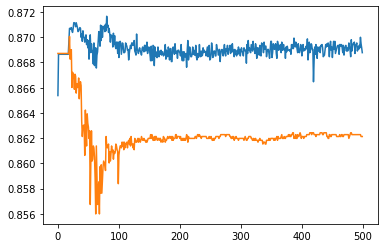

In [84]:
# Neural network
# code from HW7
batch_size = 218
epochs = 500
num_classes = 3 
nodes_layers = [100,100,100]
kernel_weight = 0.003
bias_weight = 0.003
activity_weight = 0.0

#reset the model 
model = tf.keras.models.Sequential()
# firzt hidden layer
model.add(tf.keras.layers.Dense(nodes_layers[0], activation='relu', input_shape=(1308,)))
# hidden layers 
for s in nodes_layers[1:]:
    model.add(tf.keras.layers.Dense(units = s,  activation = 'relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(kernel_weight), 
                                    bias_regularizer=tf.keras.regularizers.l2(bias_weight) ))
    model.add(tf.keras.layers.Dropout(0.3))

# output layer 
model.add(tf.keras.layers.Dense(1,  activation='sigmoid'))

# Summary 
print(model.summary())


# compile it 


optimize = tf.keras.optimizers.Adam(learning_rate=0.0007, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer=optimize, loss='binary_crossentropy', metrics=['acc'])

# fit it

history_basic = model.fit(X_train_smaller_array, y_train_array, batch_size=batch_size, epochs=epochs,  validation_split=.3, verbose=True)

loss, acc = model.evaluate(X_train_smaller_array, y_train_array, verbose=True)
print("Training:",loss,acc)

valacc = history_basic.history['val_acc'][-1]
print("Val Acc:",valacc)
print("Diff:", acc-valacc)



plt.plot(history_basic.history['acc'])
plt.plot(history_basic.history['val_acc']);


In [85]:
# your code here
preds = model.predict_classes(X_test_smaller_array).flatten()
print(preds.shape)

(5566,)


In [86]:
confusion_matrix_nn = confusion_matrix(y_test_array, preds)
print(confusion_matrix_nn)

[[4786   49    0]
 [ 577    6    0]
 [ 141    7    0]]


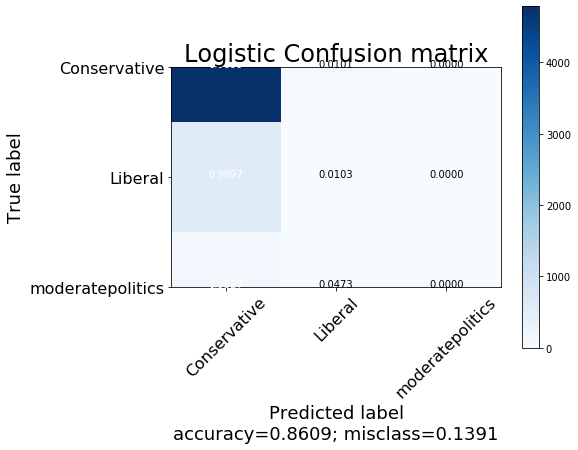

In [87]:
plot_confusion_matrix(cm = confusion_matrix_nn,
                      target_names = ['Conservative', 'Liberal', 'moderatepolitics'],
                      title='Logistic Confusion matrix',
                      cmap=None,
                      normalize=True)

In [102]:
from tensorflow.keras import backend as K
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

In [331]:
## Neural network 2
## code from HW7
#batch_size = 218
#epochs = 500
#num_classes = 3 
#nodes_layers = [100,100,100]
#kernel_weight = 0.003
#bias_weight = 0.003
#activity_weight = 0.0
#
##reset the model 
#model = tf.keras.models.Sequential()
## firzt hidden layer
#model.add(tf.keras.layers.Dense(nodes_layers[0], activation='relu', input_shape=(1308,)))
## hidden layers 
#for s in nodes_layers[1:]:
#    model.add(tf.keras.layers.Dense(units = s,  activation = 'relu', 
#                                    kernel_regularizer=tf.keras.regularizers.l2(kernel_weight), 
#                                    bias_regularizer=tf.keras.regularizers.l2(bias_weight) ))
#    model.add(tf.keras.layers.Dropout(0.3))
#
## output layer 
#model.add(tf.keras.layers.Dense(1,  activation='softmax'))
#
## Summary 
#print(model.summary())
#
#
## compile it 
#
#
#optimize = tf.keras.optimizers.Adam(learning_rate=0.0007, beta_1=0.9, beta_2=0.999, amsgrad=False)
#
#model.compile(optimizer=optimize, loss=loss_fn, metrics=['acc'])
#
## fit it
#
#history_basic = model.fit(X_train_smaller_array, y_train_array, batch_size=batch_size, epochs=epochs,  validation_split=.3, verbose=True)
#
#loss, acc = model.evaluate(X_train_smaller_array, y_train_array, verbose=True)
#print("Training:",loss,acc)
#
#valacc = history_basic.history['val_acc'][-1]
#print("Val Acc:",valacc)
#print("Diff:", acc-valacc)
#
#
#
#plt.plot(history_basic.history['acc'])
#plt.plot(history_basic.history['val_acc']);
#

In [105]:
## your code here
#preds = model.predict_classes(X_test_smaller_array).flatten()
#print(preds.shape)

In [106]:
#confusion_matrix_nn2 = confusion_matrix(y_test_array, preds)
#print(confusion_matrix_nn2)

In [107]:
#plot_confusion_matrix(cm = confusion_matrix_nn2,
#                      target_names = ['Conservative', 'Liberal', 'moderatepolitics'],
#                      title='Logistic Confusion matrix',
#                      cmap=None,
#                      normalize=True)

### Model Results

In [316]:
model_comparison_table = pd.DataFrame({"Model Type":['Random Forest', 'Neural Net', 
                                                     "PCA", "Lasso",
                                                     "Logistic Regression"],
                                      "Test Score": [(random_forest_test_score/100), 
                                                     history_basic.history['val_acc'][-1],
                                                     cv_scores[2], test_score_lasso, 
                                                     test_score_multi]})

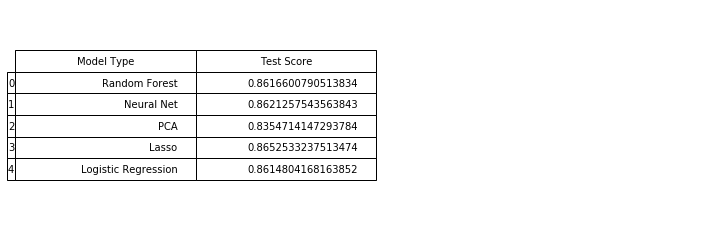

In [317]:
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

tabla = table(ax, model_comparison_table, loc='left', colWidths=[0.3]*len(df.columns))  # where df is your data frame
tabla.auto_set_font_size(False) # Activate set fontsize manually
tabla.set_fontsize(10) # if ++fontsize is necessary ++colWidths
tabla.scale(1.8, 1.8) # change size table


plt.savefig('model_comparison_df.png')



----

**Real Prediction: 2018 Election Politics Reddit Channel**

In [172]:
politics_one = pd.read_csv("politics_one.csv")
#print(len(politics_one))

In [173]:
politics_two= pd.read_csv("politics_two.csv")
#print(len(politics_two))

In [187]:
politics_df = pd.concat([politics_one, politics_two], axis = 0)
#print(len(politics_df))

In [189]:
politics_df = politics_df.drop(columns = ["Unnamed: 0", "subreddit_class"])
politics_df.head()

,dead,student,girl,probe,48,ll,thinks,asks,45,allegations,...,optimal,mammograms,85.6,invaded,viewpoints,smug,selection,lib,uterus,viewpoint
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [234]:
# Run Random Forest
conservative_perc = []
liberal_perc = []
moderate_perc = []
sub_total = []


predictions_final = model_rf.predict(politics_df)

sub_df_temp=(pd.DataFrame({'subreddit_class': predictions_final})['subreddit_class'].value_counts())
conservative_perc.append(sub_df_temp[0])
liberal_perc.append(sub_df_temp[1])

try:
    moderate_perc.append(sub_df_temp[2])
except:
    moderate_perc.append(0)
sub_total.append(len(predictions_final))


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    7.0s finished


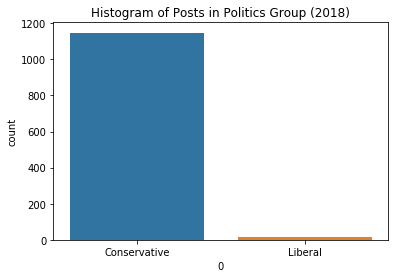

In [235]:
# Create Histogram
sns.countplot(x=predictions_balanced[0])
plt.title("Histogram of Posts in Politics Group (2018)")
plt.show;

In [236]:
subreddit_files = ["Economics.csv","arizonapolitics.csv",'wisconsinpolitics.csv']

In [237]:

for x in subreddit_files:
    sub_df = pd.read_csv(x)
    sub_df = sub_df.drop(columns = ["Unnamed: 0", "subreddit_class"])
    predictions_final = model_rf.predict(sub_df)
    sub_df_temp=(pd.DataFrame({'subreddit_class': predictions_final})['subreddit_class'].value_counts())
    conservative_perc.append(sub_df_temp[0])
    liberal_perc.append(sub_df_temp[1])
    try:
        moderate_perc.append(sub_df_temp[2])
    except:
        moderate_perc.append(0)
    sub_total.append(len(predictions_final))


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished


In [291]:
results_df = pd.DataFrame({"Subreddit Group":['Politics',"Economics",
                                              "arizonapolitics",'wisconsinpolitics'],
                           "Conservative Count":conservative_perc,
                          "Liberal Count":liberal_perc,
                          "Moderate Count":moderate_perc,
                          "Total Count":sub_total})

results_df['Conservative Percent']=round(((results_df['Conservative Count']/results_df['Total Count'])*100),1)
results_df['Liberal Percent']=round(((results_df['Liberal Count']/results_df['Total Count'])*100),1)
results_df['Moderate Percent']=round(((results_df['Moderate Count']/results_df['Total Count'])*100),1)

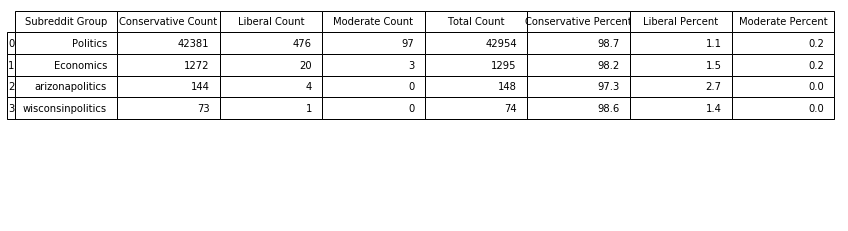

In [304]:
from pandas.plotting import table

ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

tabla = table(ax, results_df, loc='upper right', colWidths=[0.17]*len(df.columns))  # where df is your data frame
tabla.auto_set_font_size(False) # Activate set fontsize manually
tabla.set_fontsize(10) # if ++fontsize is necessary ++colWidths
tabla.scale(1.8, 1.8) # change size table


plt.savefig('results_df.png')


In [245]:
results_df

# 2 of 9 House seats switched to democrats in Arizona in 2018
# No seats switched in Wisconsin in 2018

,Subreddit Group,Conservative Count,Liberal Count,Moderate Count,Total Count,Conservative Percent,Liberal Percent,Moderate Percent
0,Politics,42381,476,97,42954,98.666015,1.108162,0.225823
1,Economics,1272,20,3,1295,98.223938,1.544402,0.231660
2,arizonapolitics,144,4,0,148,97.297297,2.702703,0.000000
3,wisconsinpolitics,73,1,0,74,98.648649,1.351351,0.000000


-----

**Balanced Panel Analysis** <br>
Used Resampling to balance the panels to avoid biasing the predictions

In [149]:
test = X_test_smaller.copy()
test['reddit_class'] = y_test
#print(test['reddit_class'])

# Indices of each class' observations 
i_class0 = np.where(test['reddit_class'] == 1)[0]
i_class1 = np.where(test['reddit_class'] == 0)[0]

#i_class0 = np.where(test['reddit_class'] == 'Liberal')[0]
#i_class1 = np.where(test['reddit_class'] == 'Conservative')[0]

#print(i_class0)
#print(i_class1)

# Number of observations in each class
n_class0 = len(i_class0)
n_class1 = len(i_class1)

# # For every observation in class 0, randomly sample from class 1 with replacement
i_class1_upsampled = np.random.choice(i_class1, size=n_class0, replace=False)

# # Join together class 0's upsampled target vector with class 1's target vector
test_balanced = np.concatenate((test.iloc[i_class1_upsampled,:], test.iloc[i_class0,:]))

# Turn into dataframe
test_balanced = pd.DataFrame(test_balanced, columns = np.asarray(test.columns))

# separate X and y
X_test_balanced = test_balanced.iloc[:,test_balanced.columns != 'reddit_class']
y_test_balanced = test_balanced.iloc[:,test_balanced.columns == 'reddit_class']

print('shape of X_test_balanced:', X_test_balanced.shape)
print('shape of y_test_balanced:', y_test_balanced.shape)
print('shape of X_test_smaller:', X_test_smaller.shape)
print('shape of y_test:', y_test.shape)


#test_balanced.head()
#test_balanced["reddit_class"].value_counts()

shape of X_test_balanced: (1166, 1308)
shape of y_test_balanced: (1166, 1)
shape of X_test_smaller: (5566, 1308)
shape of y_test: (5566, 1)


In [150]:
predictions_balanced = model_rf.predict(X_test_balanced)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.1s finished


In [152]:
predictions_balanced = pd.DataFrame(predictions_balanced)
predictions_balanced.head()

,0
0,Conservative
1,Conservative
2,Conservative
3,Conservative
4,Conservative


In [155]:
y_test_balanced.loc[y_test_balanced["reddit_class"] == 0] = "Conservative"
y_test_balanced.loc[y_test_balanced["reddit_class"] == 1] = "Liberal"

y_test_balanced.head()

/opt/anaconda3/envs/tfcs109a/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/anaconda3/envs/tfcs109a/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/anaconda3/envs/tfcs109a/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

,reddit_class
0,Conservative
1,Conservative
2,Conservative
3,Conservative
4,Conservative


In [156]:
#Perfromance Evaluation
random_forest_test_score_balanced = accuracy_score(y_test_balanced, predictions_balanced)*100

print("Random Forest: Accuracy, Testing Set :  {:0.2f}%".format(random_forest_test_score_balanced))

Random Forest: Accuracy, Testing Set :  50.69%


In [164]:
predictions_balanced

,0
0,Conservative
1,Conservative
2,Conservative
3,Conservative
4,Conservative
...,...
1161,Conservative
1162,Conservative
1163,Conservative
1164,Conservative


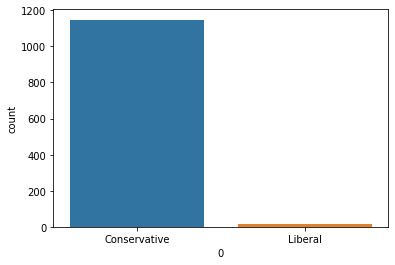

In [169]:
sns.countplot(x=predictions_balanced[0],label=True)
plt.show;

----

**Run Model with Larger Sample Size**

In [369]:
X_train_medium.shape

(22264, 3000)

In [370]:
train = X_train_smaller.copy()
train['reddit_class'] = y_train

test = X_test_smaller.copy()
test['reddit_class'] = y_test

# Indices of each class' observations 
i_class0 = np.where(test['reddit_class'] == 1)[0]
i_class1 = np.where(test['reddit_class'] == 0)[0]

# Number of observations in each class
n_class0 = len(i_class0)
n_class1 = len(i_class1)

# # randomly sample 3000 observations from class 0 with replacement
i_class0_upsampled = np.random.choice(i_class0, size=13000, replace=True)

# downsample class 1
#i_class1_downsampled = np.random.choice(i_class1, size=5300, replace=False)

# Join together class 0's upsampled target vector with class 1's target vector
train_balanced = np.concatenate((train.iloc[i_class0,:], train.iloc[i_class0_upsampled,:], train.iloc[i_class1,:]))

# Turn into dataframe
train_balanced = pd.DataFrame(train_balanced, columns = np.asarray(train.columns))

# separate X and y
X_train_smaller_balanced = train_balanced.iloc[:,train_balanced.columns != 'reddit_class']
y_train_smaller_balanced = train_balanced.iloc[:,train_balanced.columns == 'reddit_class']

In [371]:
X_train_smaller_balanced.shape

(18418, 1308)

In [372]:
X_train_medium_balanced.head()

,dead,student,girl,probe,48,ll,thinks,asks,45,allegations,...,regular,doxxed,tossed,academics,incoming,tanks,gathered,reviewing,cow,blew
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [373]:
y_train_medium_balanced.shape, X_train_medium_balanced.shape

((14109, 1), (14109, 3000))

In [374]:
y_train.describe()

,class
count,22264.000000
mean,0.157878
std,0.431337
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,2.000000


In [375]:
y_train_medium_balanced.describe()

,reddit_class
count,11292.000000
mean,0.164098
std,0.397375
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,2.000000


In [376]:
X_train_medium_balanced.head()

,dead,student,girl,probe,48,ll,thinks,asks,45,allegations,...,regular,doxxed,tossed,academics,incoming,tanks,gathered,reviewing,cow,blew
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [377]:
# Best Random Forest Tree
model = RandomForestClassifier(n_estimators=55, max_depth=40, max_features=800) # code from section 7
model.fit(X_train_smaller_balanced, y_train_smaller_balanced['reddit_class'])

#Predict
y_pred_train = model.predict(X_train_smaller_balanced)
y_pred_test = model.predict(X_test_smaller)

#Perfromance Evaluation
random_forest_train_score = accuracy_score(y_train_smaller_balanced, y_pred_train)*100
random_forest_test_score = accuracy_score(y_test, y_pred_test)*100

print("Random Forest: Accuracy, Training Set : {:0.2f}%".format(random_forest_train_score))
print("Random Forest: Accuracy, Testing Set :  {:0.2f}%".format(random_forest_test_score))

Random Forest: Accuracy, Training Set : 89.09%
Random Forest: Accuracy, Testing Set :  84.64%


In [379]:
# multi regression model   Code from HW5 solutions
multi_regr = LogisticRegression(C=100000, solver = "lbfgs", max_iter=100000, multi_class="ovr", random_state=81, verbose=1)
multi_regr.fit(X_train_smaller_balanced, y_train_smaller_balanced)
print("Done: Step 1")

# predictions
y_train_pred_multi = multi_regr.predict(X_train_smaller_balanced) 
y_test_pred_multi = multi_regr.predict(X_test_smaller)
print("Done: Step 2")


# accuracy
train_score_multi = accuracy_score(y_train_smaller_balanced, y_train_pred_multi)
test_score_multi = accuracy_score(y_test, y_test_pred_multi)

print('Training set accuracy for multiple logistic regression = ', train_score_multi)
print('Test set accuracy for multiple logistic regression = ', test_score_multi)

/opt/anaconda3/envs/tfcs109a/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Done: Step 1
Done: Step 2
Training set accuracy for multiple logistic regression =  0.8901075035291562
Test set accuracy for multiple logistic regression =  0.8503413582464966


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.0min finished
